# The spark version is 2.4.3 but if the link fails go to and see which is the spark version available


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").getOrCreate()
file_path = "drive/My Drive/BIG DATA PROJECT/clean_data/"

In [0]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,10)

In [0]:
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

df_accidents = sc.read.csv(file_path+'2010/accidents.csv', header=True)
for year in years:
  new_df = sc.read.csv(file_path+year+'/accidents.csv', header=True)
  df_accidents = df_accidents.union(new_df)
  
df_vehicles = sc.read.csv(file_path+'2010/vehicles.csv', header=True)
for year in years:
  new_df = sc.read.csv(file_path+year+'/vehicles.csv', header=True)
  df_vehicles = df_vehicles.union(new_df)
df_vehicles.show()

+------------------+---------------------------+----------------+----------------+----------------+-----------------+-----------------+
|Número d'expedient|Descripció tipus de vehicle|Descripció model|Descripció marca|Descripció color|Descripció carnet|Antiguitat carnet|
+------------------+---------------------------+----------------+----------------+----------------+-----------------+-----------------+
|       2010S002961|                    Turismo|            GOLF|      VOLKSWAGEN|      Desconegut|                B|                3|
|       2010S003114|                 Ciclomotor|              YR|          YAMAHA|           Negre|               AM|                1|
|       2010S001244|                  Furgoneta|        BERLINGO|         CITROEN|           Blanc|                B|                9|
|       2010S001244|                       Taxi|          TOLEDO|            SEAT|          Altres|              BTP|               16|
|       2010S001421|                  Furgoneta|

# In this section vehicles involved in accidents in BCN will be analyzed

## Fisrt, the study will show the most danger car colors.

In [0]:
sc.conf.set("spark.sql.crossJoin.enabled", "true")
df_va = df_accidents.select('Número d\'expedient').dropDuplicates().join(df_vehicles, ["Número d'expedient"])
worst_colors = df_va.groupby('Descripció color').count().orderBy("count", ascending=False)

In [0]:
from functools import reduce

oldColumns = worst_colors.schema.names
newColumns = ["color", "number"]

worst_colors = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), worst_colors)
worst_colors = worst_colors.filter(worst_colors.color!="Desconegut")
worst_colors = worst_colors.filter(worst_colors.color!="Altres")
worst_colors.show()

+----------+------+
|     color|number|
+----------+------+
|     Negre| 39432|
|      Gris| 35387|
|     Blanc| 32126|
|      Blau| 13861|
|   Vermell| 13579|
|      Verd|  3819|
|Negre/Groc|  3638|
|      Groc|  2915|
|   granate|  1194|
|  Platejat|  1023|
|     Marró|   835|
|   Taronja|   778|
|     Beige|   429|
|    Daurat|   308|
|   Violeta|   187|
|      Rosa|   121|
+----------+------+



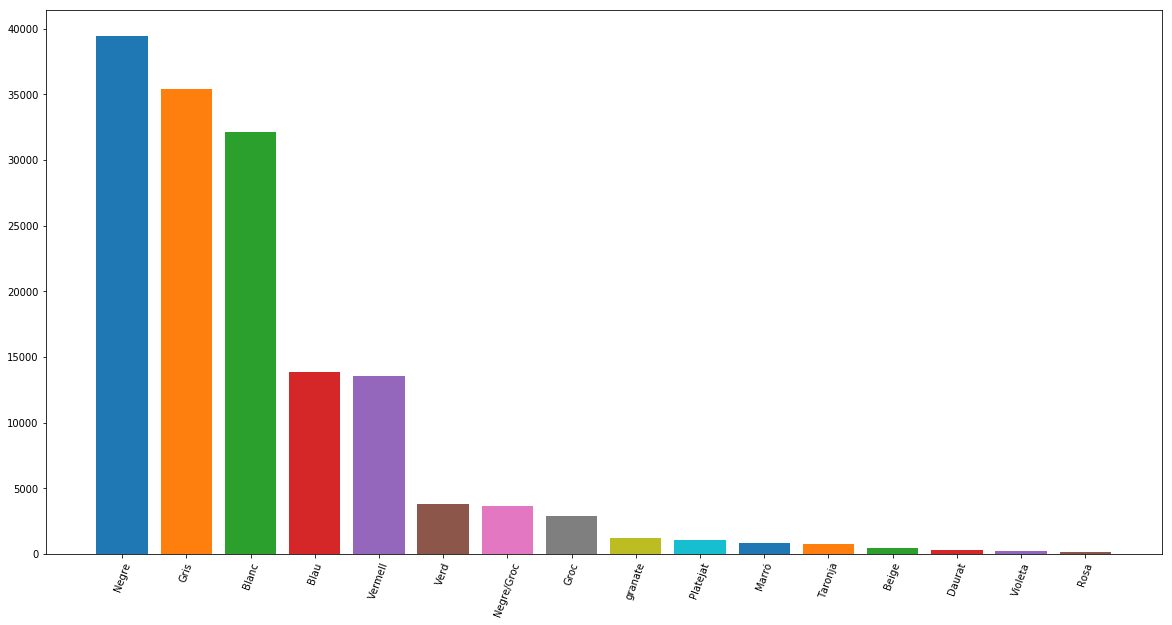

In [0]:
for color in worst_colors.collect():
  plt.bar(color.color, color.number)
  plt.xticks(rotation=70)
plt.show()

As we can see, the majority of cars involved in traffic accidents are black, gray or white. It should consider these three colors are also the most common, so this result doesn't mean they are the most danger at all.

## Are the most inexperienced drivers the most involucrated in traffic accidents?

In [0]:
sc.conf.set("spark.sql.crossJoin.enabled", "true")
df_va = df_accidents.select('Número d\'expedient').dropDuplicates().join(df_vehicles, ["Número d'expedient"])
worst_antiquity = df_va.groupby('Antiguitat carnet').count().orderBy("count", ascending=False)

oldColumns = worst_antiquity.schema.names
newColumns = ["antiguitat", "number"]
worst_antiquity = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), worst_antiquity)

worst_antiquity = worst_antiquity.filter(worst_antiquity.antiguitat!="Desconegut")
worst_antiquity.show()

+----------+------+
|antiguitat|number|
+----------+------+
|         1|  7051|
|         2|  6838|
|         4|  6768|
|         5|  6689|
|         3|  6583|
|         6|  6402|
|         7|  6079|
|         8|  5801|
|         9|  5336|
|        10|  4902|
|        11|  4169|
|        12|  3802|
|        13|  3584|
|        14|  3409|
|        15|  3211|
|        16|  3150|
|        22|  3149|
|        19|  3119|
|        18|  3098|
|        21|  3096|
+----------+------+
only showing top 20 rows



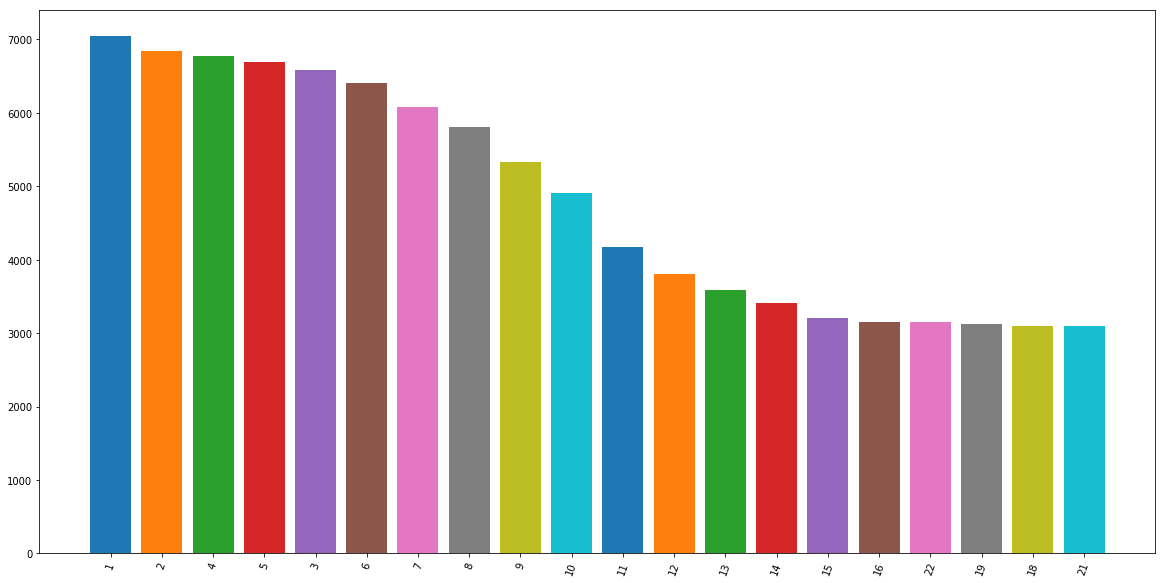

In [0]:
for color in worst_antiquity.collect()[:20]:
  plt.bar(color.antiguitat, color.number)
  plt.xticks(rotation=70)
plt.show()

As we can observe, as fewer years of experience with a vehicle, is easier to have an accident. After the years, the number of traffic accidents is pretty constant.

## Which type of vehicles are more involucrated in accidents in BCN?

In [0]:
sc.conf.set("spark.sql.crossJoin.enabled", "true")
df_va = df_accidents.select('Número d\'expedient').dropDuplicates().join(df_vehicles, ["Número d'expedient"])
worst_type = df_va.replace("Turisme",  "Turismo").replace("Motocicleta",  "Moto").replace("Ciclomotor",  "Moto").groupby('Descripció tipus de vehicle').count().orderBy("count", ascending=False)

oldColumns = worst_type.schema.names
newColumns = ["tipus", "number"]
worst_type = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), worst_type)

worst_type = worst_type.filter(worst_type.tipus!="Otros veh¡c. a motor")
worst_type.show()

+--------------------+------+
|               tipus|number|
+--------------------+------+
|             Turismo| 69909|
|                Moto| 60551|
|           Furgoneta| 10732|
|                Taxi|  8846|
|           Bicicleta|  6037|
|             Autobús|  4208|
|    Camión <= 3,5 Tm|  2064|
|     Camión > 3,5 Tm|  1068|
|Camió rígid <= 3,...|   487|
|        Todo terreno|   391|
|        Tractocamión|   317|
|Camió rígid > 3,5...|   267|
|             Autocar|   250|
|Veh. mobilitat pe...|   128|
|  Autobús articulado|   119|
|   Autobús articulat|    99|
|       Tractor camió|    84|
|         Tot terreny|    80|
|      Tranv¡a o tren|    63|
|Altres vehicles a...|    62|
+--------------------+------+
only showing top 20 rows



We consider all "motocicleta" and "cilomotor" as "moto"

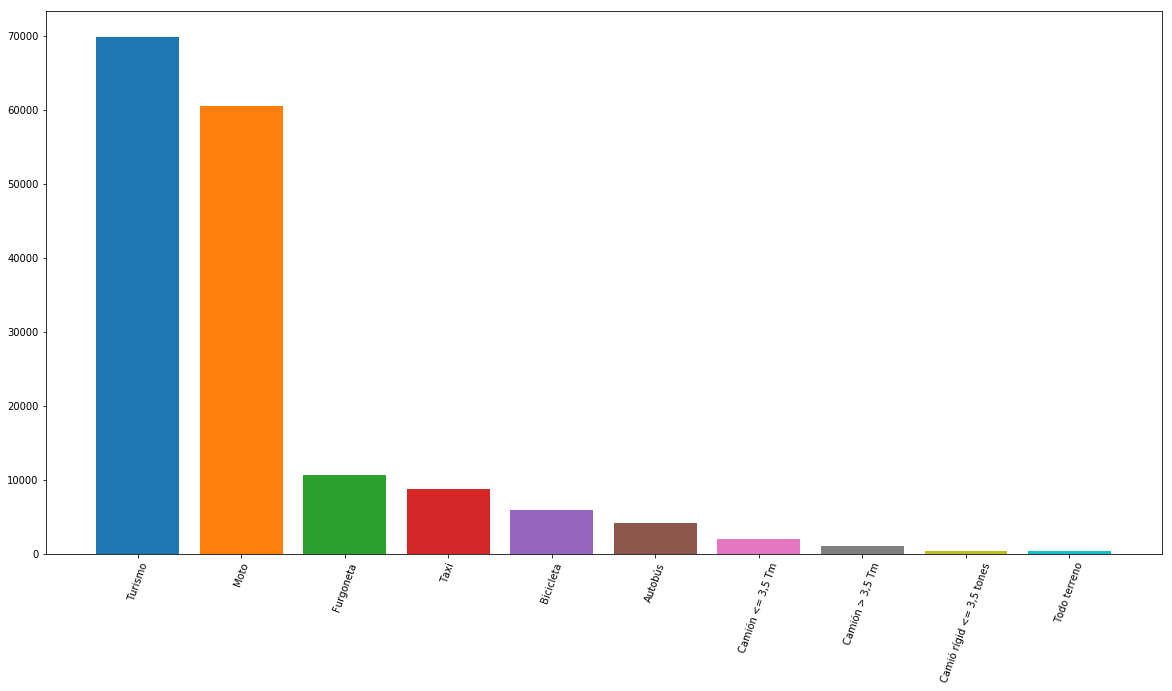

In [0]:
for color in worst_type.collect()[:10]:
  plt.bar(color.tipus, color.number)
  plt.xticks(rotation=70)
plt.show()

Private cars and motorbikes are the most common involucrated in accidents.